<a href="https://colab.research.google.com/github/JohnnyNewman/MA/blob/main/Evaluation_Notebook_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

In [ ]:
# check if already in right local directory
# otherwise clone the repo from github and change directory

cwd = os.getcwd()
print(os.path.split(cwd))

if not os.path.split(cwd)[1] == "MA":
    !git clone https://www.github.com/JohnnyNewman/MA.git
    os.chdir('MA')

In [1]:
import pickle

In [2]:
import torch

In [3]:
from base import *

In [4]:
# load data

dataset = pickle.load(open("save/T007/full_dataset.p", "rb"))
train_dataset = pickle.load(open("save/T007/train_dataset.p", "rb"))
test_dataset = pickle.load(open("save/T007/test_dataset.p", "rb"))

In [ ]:
# load neural network models

In [ ]:
#net = torch.load("net6.pt", map_location=torch.device('cpu')).eval()

In [ ]:
#tm2 = torch.load("net6_tm2.pt", map_location=torch.device('cpu')).eval()

In [5]:
PATH = "lightning_logs/version_84/checkpoints/epoch=2447.ckpt"
model = AirfoilModel.load_from_checkpoint(PATH)

In [ ]:
# display network architecture

model

In [6]:
ma_train, aoa_train, dv_train, x_train, y_train, c_l_train, c_d_train, E_train = train_dataset[:]
ma_test, aoa_test, dv_test, x_test, y_test, c_l_test, c_d_test, E_test = test_dataset[:]



In [58]:
aoa_train.max(), aoa_train.min()

(tensor(24.9536), tensor(-9.9666))

In [ ]:
model.device

In [8]:
model.double()

AirfoilModel(
  (layer_0): Conv1d(2, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (layer_11): Conv1d(16, 8, kernel_size=(3,), stride=(1,), padding=(1,))
  (layer_12): Conv1d(16, 8, kernel_size=(3,), stride=(1,), padding=(1,))
  (layer_13): Conv1d(16, 8, kernel_size=(3,), stride=(1,), padding=(1,))
  (layer_14): Conv1d(16, 8, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu_11): ReLU()
  (relu_12): ReLU()
  (relu_13): ReLU()
  (relu_14): ReLU()
  (layer_2): Conv1d(32, 8, kernel_size=(5,), stride=(2,), padding=(1,))
  (relu_2): ReLU()
  (layer_3): Linear(in_features=287, out_features=8, bias=True)
  (layer_5): Linear(in_features=66, out_features=32, bias=True)
  (layer_6): Linear(in_features=32, out_features=32, bias=True)
  (relu_6): ReLU()
  (layer_7): Linear(in_features=32, out_features=32, bias=True)
  (relu_7): ReLU()
  (layer_8): Linear(in_features=32, out_features=32, bias=True)
  (relu_8): ReLU()
  (layer_9): Linear(in_features=32, out_features=32, bias=True)
  (relu_9)

In [9]:
# produce latent vectors from input

x_3_train = model.airfoil_encoder(x_train)

z_mu_train, z_var_train = model.latent_encoder(x_3_train, ma_train, aoa_train)
#Z_test, var_test = net.encoder(x_test).detach().view(-1, 64)

In [10]:


x_3_test = model.airfoil_encoder(x_test)

z_mu_test, z_var_test = model.latent_encoder(x_3_test, ma_test, aoa_test)

In [ ]:
z_std_test = torch.exp(z_var_test / 2)
q = torch.distributions.Normal(z_mu_test, z_std_test)
z = q.rsample()

In [53]:
z2_test = model.process_latent(z_mu_test)

In [45]:
z2_train = model.process_latent(z_mu_train)

In [ ]:
n_samples = 1000
z = q.rsample((n_samples,))

In [ ]:
z2.shape

In [ ]:
z2 = model.process_latent(z)

In [ ]:
c_d_pred_samples = torch.zeros([n_samples, 276])
c_l_pred_samples = torch.zeros([n_samples, 276])
for i in range(z2.shape[0]):
    c_l_pred, c_d_pred, _ = model.predict_coefficients(z2[i])
    #print(c_l_pred, c_d_pred)
    #c_d_list.append(c_d_pred)
    c_d_pred_samples[i] = c_d_pred
    c_l_pred_samples[i] = c_l_pred

In [ ]:
c_d_pred_samples.mean(axis=0)[:10], c_d_pred_samples.var(axis=0)[:10], model.predict_coefficients(model.process_latent(z_mu_test))[1][:10]

In [ ]:
torch.mean(torch.Tensor(c_d_list))

In [11]:
c_l_train_pred, c_d_train_pred, _ = model.predict_coefficients(model.process_latent(z_mu_train))
c_l_test_pred, c_d_test_pred, _ = model.predict_coefficients(model.process_latent(z_mu_test))

In [13]:
c_d_train_pred

tensor([0.0096, 0.0507, 0.0179,  ..., 0.1868, 0.3037, 0.2309],
       dtype=torch.float64, grad_fn=<SelectBackward>)

In [29]:
from sklearn.manifold import TSNE

(1560, 2)


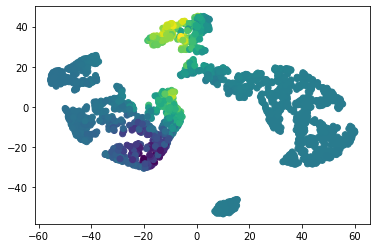

In [46]:
# create 2-dimensional representation of the latent vectors for vizualisation
# using t-distributed stochastic neighbor embedding (t-SNE)

tsne = TSNE(metric="cosine")
#emb = tsne.fit_transform(x_3.view(276, 64).detach().numpy())
emb = tsne.fit_transform(z2_train.view(-1, 64).detach().numpy())
print(emb.shape)

plt.scatter(emb[:,0], emb[:,1], c=E_train)

In [ ]:
# Try to fit a Gaussian Process Regressor to the latent vectors (input) and c_D values (output)

In [14]:
from sklearn.gaussian_process.kernels import PairwiseKernel, Product
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel, WhiteKernel)


In [15]:
pk = PairwiseKernel(metric="cosine")
kernel = Product(pk, pk)
kernel = ConstantKernel()*pk*pk + WhiteKernel(noise_level=1e-05, noise_level_bounds=(1e-12, 1e-03))

In [47]:
kernel = PairwiseKernel(metric="cosine") + WhiteKernel(noise_level=1e-05, noise_level_bounds=(1e-12, 1e-03))

In [40]:
kernel = RBF() + WhiteKernel(noise_level=1e-05, noise_level_bounds=(1e-12, 1e-03))

In [ ]:
gp = GaussianProcessRegressor(kernel=kernel, random_state=0, alpha=0.000001,n_restarts_optimizer=3).fit(Z_train, c_D_train)
print(gp.kernel_)
print(gp.score(Z_train, c_D_train))
print(gp.score(Z_test, c_D_test))
print(gp.log_marginal_likelihood())

In [48]:
gp = GaussianProcessRegressor(kernel=kernel, random_state=0, alpha=0.000001,n_restarts_optimizer=1).fit(z_mu_train.view(-1, 32).detach().numpy(), c_d_train)
print(gp.kernel_)
print(gp.score(z_mu_train.view(-1, 32).detach().numpy(), c_d_train))
print(gp.score(z_mu_test.view(-1, 32).detach().numpy(), c_d_test))
print(gp.log_marginal_likelihood())

PairwiseKernel(gamma=1.0, metric=cosine) + WhiteKernel(noise_level=0.001)
0.9121660812751384
0.9017465117347058
1626.844448358713


In [54]:
gp = GaussianProcessRegressor(kernel=kernel, random_state=0, alpha=0.000001,n_restarts_optimizer=1).fit(z2_train.view(-1, 64).detach().numpy(), c_d_train)
print(gp.kernel_)
print(gp.score(z2_train.view(-1, 64).detach().numpy(), c_d_train))
print(gp.score(z2_test.view(-1, 64).detach().numpy(), c_d_test))
print(gp.log_marginal_likelihood())

PairwiseKernel(gamma=3.0770534432116476, metric=cosine) + WhiteKernel(noise_level=0.00079)
0.973935246265447
0.9739189949617298
3249.455860125102


In [ ]:
print(gp.score(z_mu.view(-1, 32).detach().numpy(), c_d))


In [ ]:
Z_train.shape, y_train.shape

In [ ]:
c_D_train_predicted = gp.predict(Z_train)
c_D_test_predicted = gp.predict(Z_test)

In [49]:
c_D_train_predicted = gp.predict(z_mu_train.view(-1, 32).detach().numpy())
c_D_test_predicted = gp.predict(z_mu_test.view(-1, 32).detach().numpy())

In [55]:
c_D_train_predicted = gp.predict(z2_train.view(-1, 64).detach().numpy())
c_D_test_predicted = gp.predict(z2_test.view(-1, 64).detach().numpy())

In [18]:
c_D_train = c_d_train
c_D_test = c_d_test

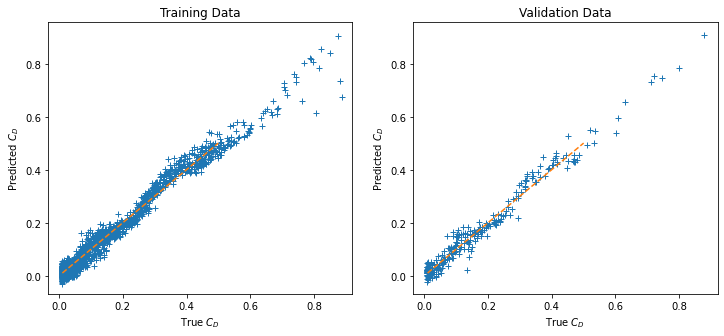

In [56]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)

#plt.plot(y_pred)
plt.plot(c_D_train, c_D_train_predicted, '+')
plt.plot([0.01, 0.5], [0.01, 0.5], "--")

plt.gca().set_xlim([0.008, 0.042])
plt.gca().set_ylim([0.008, 0.042])
ax1 = plt.gca()
ax1.set_ylabel("Predicted $C_D$")
ax1.set_xlabel("True $C_D$")
ax1.set_title("Training Data")

plt.subplot(1, 2, 2)

#plt.plot(y_pred)
plt.plot(c_D_test, c_D_test_predicted, '+', label="asd")
plt.plot([0.01, 0.5], [0.01, 0.5], "--")
#plt.plot(y_pred, 'o', c="r")
ax1.set_xlim(plt.gca().get_xlim())
ax1.set_ylim(plt.gca().get_ylim())
ax2 = plt.gca()
ax2.set_ylabel("Predicted $C_D$")
ax2.set_xlabel("True $C_D$")
ax2.set_title("Validation Data")

#plt.gca().set_xlim([0.005, 0.08])
#plt.gca().set_ylim([0.005, 0.08])
pass

In [ ]:
c_D_train_predicted2 = tm2(Z_train).detach()
c_D_test_predicted2 = tm2(Z_test).detach()

In [20]:
c_D_train_predicted2 = c_d_train_pred.detach().numpy()
c_D_test_predicted2 = c_d_test_pred.detach().numpy()

Text(0.5, 1.0, 'Validation Data')

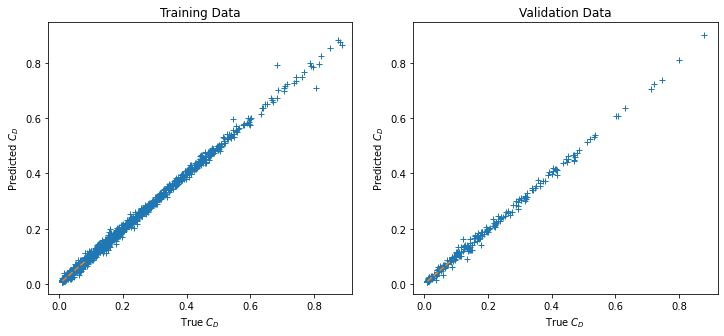

In [37]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)

#plt.plot(y_pred)
plt.plot(c_D_train, c_D_train_predicted2, '+')
plt.plot([0.01, 0.08], [0.01, 0.08], "--")

#plt.gca().set_xlim([0.008, 0.042])
#plt.gca().set_ylim([0.008, 0.042])
ax1 = plt.gca()
ax1.set_ylabel("Predicted $C_D$")
ax1.set_xlabel("True $C_D$")
ax1.set_title("Training Data")
#ax1.set_xlim([0.005, 0.042])
#ax1.set_ylim([0.005, 0.042])

plt.subplot(1, 2, 2)

#plt.plot(y_pred)
plt.plot(c_D_test, c_D_test_predicted2, '+', label="asd")
plt.plot([0.01, 0.08], [0.01, 0.08], "--")
#plt.plot(y_pred, 'o', c="r")
ax1.set_xlim(plt.gca().get_xlim())
ax1.set_ylim(plt.gca().get_ylim())
ax2 = plt.gca()
ax2.set_ylabel("Predicted $C_D$")
ax2.set_xlabel("True $C_D$")
ax2.set_title("Validation Data")
#ax2.set_xlim([0.005, 0.042])
#ax2.set_ylim([0.005, 0.042])

In [ ]:
# do a PCA decompositon of the latent vectors and fit GPR to this representation

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=10, svd_solver="full")
pca.fit(Z_train)

In [ ]:
pca.explained_variance_

In [ ]:
pca.explained_variance_ratio_.cumsum()

In [ ]:
plt.plot(pca.explained_variance_ratio_.cumsum())

In [ ]:
ls = 1 / pca.singular_values_ ** 2

In [ ]:
ls

In [ ]:
kernel = 1.0 * RBF(length_scale=ls, length_scale_bounds=(1e-7, 10.0)) #+ WhiteKernel(noise_level=1e-05, noise_level_bounds=(1e-09, 1e-04))# + ConstantKernel()

In [ ]:
gp = GaussianProcessRegressor(kernel=kernel, random_state=0, alpha=0.000001,n_restarts_optimizer=1).fit(pca.transform(Z_train), c_D_train)
print(gp.kernel_)
print(gp.score(pca.transform(Z_train), c_D_train))
print(gp.score(pca.transform(Z_test), c_D_test))
print(gp.log_marginal_likelihood())

In [ ]:
# alternatively to the TSNE embedding, I tried umap embedding
# https://umap-learn.readthedocs.io/

In [ ]:
#!pip install umap-learn

In [ ]:
#import umap

In [ ]:
#reducer = umap.UMAP()

In [ ]:
#embedding_umap = reducer.fit_transform(Z)

In [ ]:
#plt.scatter(embedding_umap[:,0], embedding_umap[:,1], c=np.clip(c_D, a_max=0.0275, a_min=0))

In [ ]:
# you will need the library 'bokeh' to display the plots
# it will be automatically installed by the following command

!pip install bokeh

In [ ]:
import bokeh

In [ ]:

from bokeh.layouts import gridplot
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource
from bokeh.models.tools import TapTool, LassoSelectTool, HoverTool
from bokeh.themes import Theme
import yaml

In [ ]:
# this will create an interactive vizualisation of the airfoils and their embedded latent vectors 
# unfortunately google colab does not allow this
# but should work locally

output_notebook()

def bkapp(doc):
    
    data = ColumnDataSource({
    "x": emb[:,0],
    "y": emb[:,1],
    "c": c_D_train.numpy(),
    "is_train": [1]*x_train.shape[0] + [0] * x_test.shape[0],
    })
    
    s1 = figure(width=50, plot_height=200, title=None, name="asd")
    s1.scatter("x", "y", source=data, size=10, fill_color=bokeh.transform.linear_cmap("c", bokeh.palettes.Plasma256, 0.0, 0.03))
    
    i = 0
    airfoil_data = ColumnDataSource({
    "x": x_train[i, 0, :].numpy(),
    "y": 10*x_train[i, 1, :].numpy(),
    "cp": y_train[i, 0, :].numpy(),    
    "cd": np.ones(192)*c_D_train[i].numpy(),
    })
    
    s2 = figure(width=50, plot_height=100)    
    #s2.circle(, x_train[i, 1, :].numpy())
    s2.scatter("x", "y", source=airfoil_data, fill_color=bokeh.transform.linear_cmap("cd", "Plasma256", 0.0, 0.05))
    
    #s3 = figure(width=50, plot_height=100)    
    s2.square("x", "cp", source=airfoil_data, fill_color=bokeh.transform.linear_cmap("cd", "Plasma256", 0.0, 0.05))
    
    hover = HoverTool(tooltips=[("c_D", "@c")])
    s1.add_tools(TapTool(), LassoSelectTool(), hover)

    p = gridplot([[s1],[s2]])

    def selection_change(attrname, old, new):
        print(attrname, old, new)
        if len(new) >= 1:
            airfoil_data.data = {k: [] for k in airfoil_data.data}
            #i = new[0]
            for i in new:
                airfoil_data.data["x"] = np.hstack((airfoil_data.data["x"], x_train[i, 0, :].numpy()))
                airfoil_data.data["y"] = np.hstack((airfoil_data.data["y"], 10*x_train[i, 1, :].numpy()))
                airfoil_data.data["cp"] = np.hstack((airfoil_data.data["cp"], y_train[i, 0, :].numpy()))
                airfoil_data.data["cd"] = np.hstack((airfoil_data.data["cd"], np.ones(192)*c_D_train[i].numpy()))
            #airfoil_data.data = {"x": x_train[i, 0, :].numpy(), "y": 10*x_train[i, 1, :].numpy(), "cp": y_train[i, 0, :].numpy() for i in new}
            #s2.circle(x_train[i, 0, :].numpy(), x_train[i, 1, :].numpy())
        pass

    data.selected.on_change('indices', selection_change)
    #hover.on_change("data", selection_change)
    
    doc.add_root(p)
    doc.theme = Theme(json=yaml.load("""
        attrs:
            Figure:
                toolbar_location: above
                height: 500
                width: 800
            Grid:
                grid_line_dash: [6, 4]
                grid_line_color: white
    """, Loader=yaml.FullLoader))

show(bkapp)